# Zadatak 3

 3.1. Generisati tri klase dvodimenzionalnih oblika. Izabrati funkciju gustine verovatnoće oblika tako da klase budu 
linearno separabilne. 

a) Za tako generisane oblike izvšiti projektovanje linearnog klasifikatora jednom od tri iterativne procedure. 
Rezultate prikazati u obliku matrice konfuzije. Detaljno opisati postupak klasifikacije. 

b) Ponoviti prethodni postupak korišćenjem metode željenog izlaza. Analizirati uticaj elemenata u matrici željenih 
izlaza na konačnu formu linearnog klasifikatora. 


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from scipy.stats import mode

#### Odbari parametara normalne raspodele i generisanje odbiraka

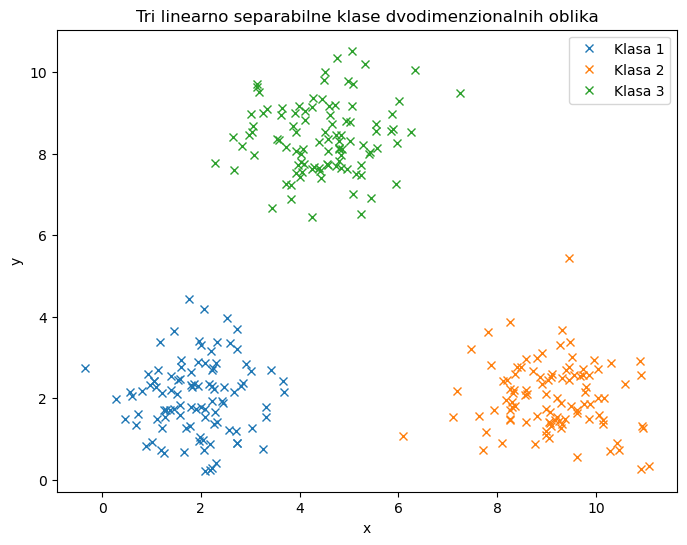

In [7]:
M1 = np.array([2, 2])
M2 = np.array([9, 2])
M3 = np.array([4.5, 8.5])

S = np.array([[0.8, 0], [0, 0.8]]) # Koristila sam istu kovariacionu matricu za sve 3 klase

N=100
np.random.seed(42)
X1 = np.random.multivariate_normal(M1, S, N).T
X2 = np.random.multivariate_normal(M2, S, N).T
X3 = np.random.multivariate_normal(M3, S, N).T

plt.figure(figsize=(8, 6))
plt.plot(X1[0,:], X1[1,:], 'x', label='Klasa 1')
plt.plot(X2[0,:], X2[1,:], 'x', label='Klasa 2')
plt.plot(X3[0,:], X3[1,:], 'x', label='Klasa 3')
plt.legend()
plt.title("Tri linearno separabilne klase dvodimenzionalnih oblika")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## a) Druga numerička metoda

Metoda za koju sam se odlučila je druga numerička metoda. Pošto imamo problem više kalsa, potrebno je projektovati klasifikator za svaki par klasa. U ovo slučaju ćemo ukupno imati 3 klasifikatora (1 i 2; 1 i 3; 2 i 3). Potom ćemo pomoću njih klasifikovati odbirke i to tako što ćemo odbirak smeštati u onu klasu koja je dobila najviše glasova.

Linearni klasifikator ima sledeći oblik klasifikacione funkcije: $$h(x) = V^{T}X + v_0 $$ Ukoliko je $h(x)$ veće od nule odbirak pripada drugoj, a ukoliko je manje od nule pripada prvoj klasi. Jednačine na osnovu kojih dobijamo nepoznate parametre su sledeće:$$ s = \frac{-\eta_1/\sigma_1^2}{-\eta_1/\sigma_1^2+\eta_2/\sigma_2^2} $$
$~$
$$ V = \left[s\Sigma_1+(1-s)\Sigma_2 \right]^{-1}(M_2-M_1) $$
$~$
$$ v_0 = - \frac{s\sigma_1^2V^TM_2+(1-s)\sigma_2^2V^TM_1}{s\sigma_1^2+(1-s)\sigma_2^2}$$

Pošto je nemoguće rešiti ove jednačine u zatvorenoj formi, potreno je primeniti iterativni numerički postupak. Ovaj postupak se oslanja na to da s ima opseg vrednosti od 0 do 1, kao i na to da $v_0$ može da se nađe u opsegu određenim vrednostima odbirka X koji je projektovan na vektor V, koji ćemo ovde označavati sa Y. Potrebno je zatim naći onaj par $s$ i $v_0$ koji pri klasifikaciji daje najmanju grešku. Zatim se na osnovu izabranog $s$ sračuna i vektor V.


In [9]:
def druga_numericka_metoda(X1, X2):
    N1 = X1.shape[1]
    N2 = X2.shape[1]
    
    M1_est = np.mean(X1, axis=1).reshape(-1,1)#reshape se radi da nam np.mean ne bi vratio kao array
    M2_est = np.mean(X2, axis=1).reshape(-1,1)
    S1_est = np.cov(X1)#zato je bilo bitno da nam dimenzija matrica bude u nacinu koji smo mi navikli, tj visoka matrica, a ne dugacka
    S2_est = np.cov(X2)    
    
    s = np.arange(0,1,10**-3)
    v0_opt_s = []#za svako s cuvamo optimalno v0 i gresku koju oni prave
    Neps_s = []
    
    for i in range(len(s)):
        V = np.linalg.inv(s[i]*S1_est + (1-s[i])*S2_est)@(M2_est-M1_est)
        # odredjivanje yj
        Y1 = V.T@X1
        Y2 = V.T@X2
        Y = np.sort(np.concatenate((Y1, Y2), axis=1)) 
        v0 = np.zeros(Y.shape[1]-1) # optimalna vrednost v0 za fiksno s
        Neps = np.zeros(Y.shape[1]-1) # Optimalno N_epsilon za fiksno s
        for j in range(Y.shape[1]-1):#PAZI, NE IDE SE DO POSLEDNJEG Y
            v0[j] = -(Y[0,j]+Y[0,j+1])/2
            Neps[j] += np.sum(Y1>-v0[j])
            Neps[j] += np.sum(Y2<-v0[j])  
        Neps_s.append(np.min(Neps))
        v0_opt_s.append(v0[np.argmin(Neps)])
    Neps_opt = min(Neps_s)
    v0_opt = v0_opt_s[np.argmin(Neps_s)]
    s_opt = s[np.argmin(Neps_s)]
    return (s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est)

In [10]:
len1 = X1.shape[1]
len2 = X2.shape[1]
len3 = X3.shape[1]

Y = np.zeros(len1+len2+len3)
Y[len1:len1+len2] = 1
Y[len1+len2:] = 2

Y1 = Y[0:len1].reshape(1,X1.shape[1])#ZASTO SU MENI OBRNUTE DIM ZA X1,X2,X3 OD NJENIH???
Y2 = Y[len1:len1+len2].reshape(1,X2.shape[1])
Y3 = Y[len1+len2:].reshape(1,X3.shape[1])



### Klasifikator za klase 1 i 2

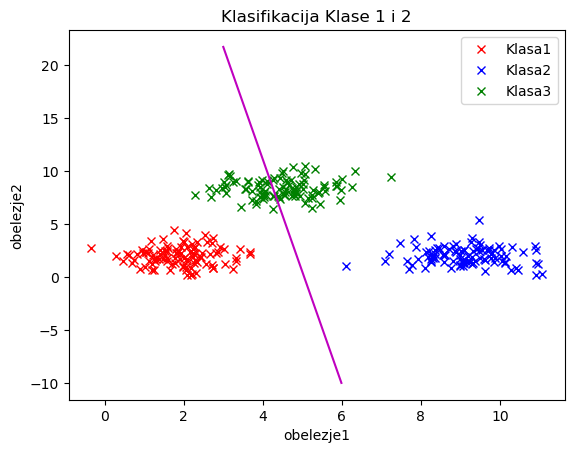

In [12]:
s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est = druga_numericka_metoda(X1, X2)
V = np.linalg.inv(s_opt*S1_est + (1-s_opt)*S2_est)@(M2_est-M1_est)
v0 = v0_opt

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.xlabel('obelezje1')
plt.ylabel('obelezje2')

x1 = np.arange(3,6,0.01)
x2 = -(v0+V[0]*x1)/V[1]
plt.plot(x1,x2,'m')
plt.title('Klasifikacija Klase 1 i 2')
plt.legend(['Klasa1', 'Klasa2', 'Klasa3'])
plt.show()

Kada projektujemo odbirke X na vektor V i kao granicu uzmemo $-v_0$ dobijamo slede'i grafik.

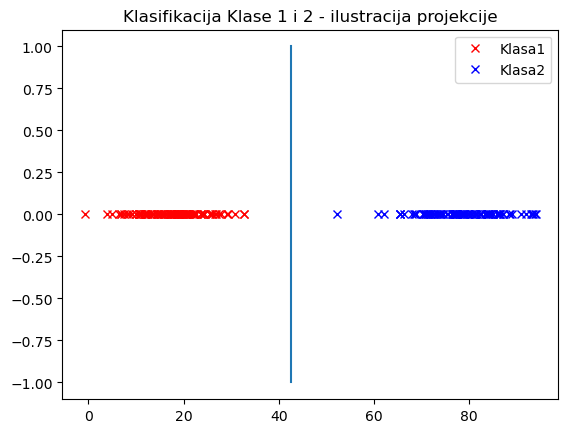

In [14]:
Y1 = V.T@X1
Y2 = V.T@X2
plt.figure()
plt.plot(Y1[0], np.zeros(Y1.shape[1]), 'rx')
plt.plot(Y2[0], np.zeros(Y2.shape[1]), 'bx')
plt.plot([-v0, -v0], [-1, 1])
plt.title('Klasifikacija Klase 1 i 2 - ilustracija projekcije')
plt.legend(['Klasa1', 'Klasa2'])
plt.show()

### Klasifikator za klase 1 i 3

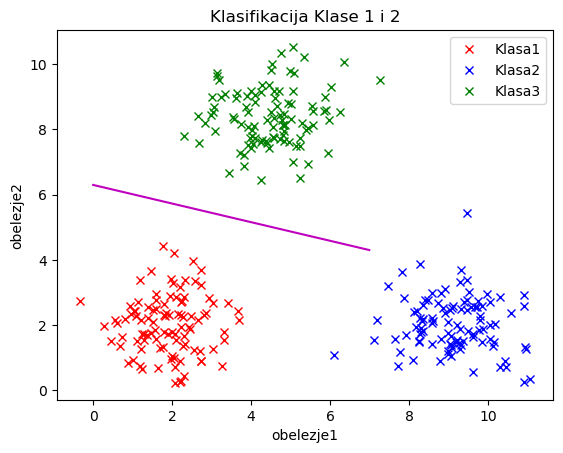

In [15]:
s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est = druga_numericka_metoda(X1, X3)
V = np.linalg.inv(s_opt*S1_est + (1-s_opt)*S2_est)@(M2_est-M1_est)
v0 = v0_opt

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.xlabel('obelezje1')
plt.ylabel('obelezje2')


x1 = np.arange(0,7,0.01)
x2 = -(v0+V[0]*x1)/V[1]
plt.plot(x1,x2,'m')
plt.title('Klasifikacija Klase 1 i 2')
plt.legend(['Klasa1', 'Klasa2', 'Klasa3'])
plt.show()

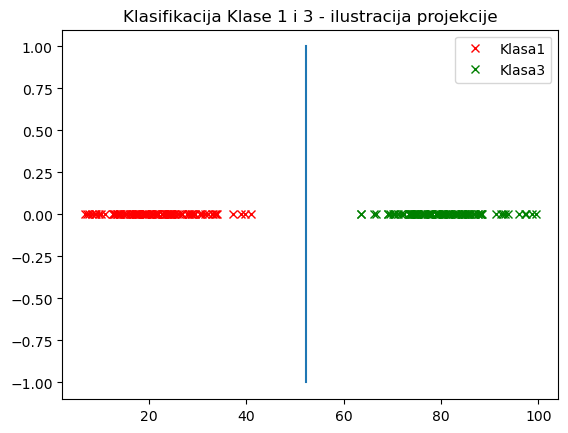

In [16]:
Y1 = V.T@X1
Y2 = V.T@X3
plt.figure()
plt.plot(Y1[0], np.zeros(Y1.shape[1]), 'rx')
plt.plot(Y2[0], np.zeros(Y2.shape[1]), 'gx')
plt.plot([-v0, -v0], [-1, 1])
plt.title('Klasifikacija Klase 1 i 3 - ilustracija projekcije')
plt.legend(['Klasa1', 'Klasa3'])
plt.show()

### Klasifikator za klase 2 i 3

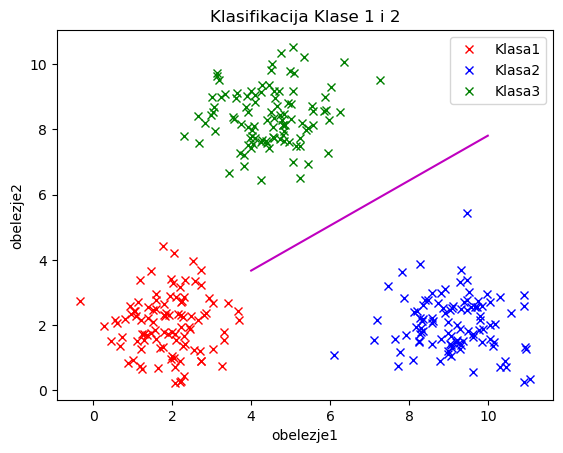

In [17]:
s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est = druga_numericka_metoda(X2, X3)
V = np.linalg.inv(s_opt*S1_est + (1-s_opt)*S2_est)@(M2_est-M1_est)
v0 = v0_opt

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.xlabel('obelezje1')
plt.ylabel('obelezje2')

x1 = np.arange(4,10,0.01)
x2 = -(v0+V[0]*x1)/V[1]
plt.plot(x1,x2,'m')
plt.title('Klasifikacija Klase 1 i 2')
plt.legend(['Klasa1', 'Klasa2', 'Klasa3'])
plt.show()

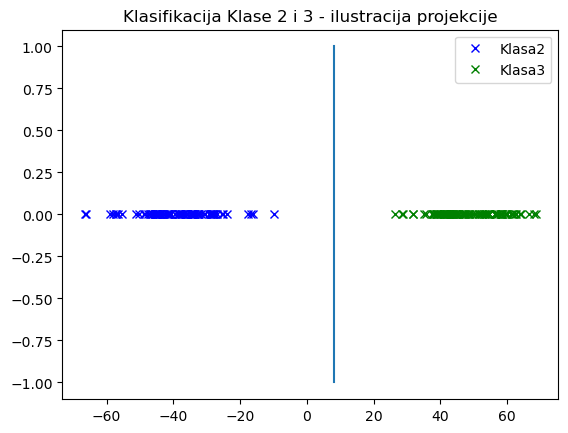

In [18]:
Y1 = V.T@X2
Y2 = V.T@X3
plt.figure()
plt.plot(Y1[0], np.zeros(Y1.shape[1]), 'bx')
plt.plot(Y2[0], np.zeros(Y2.shape[1]), 'gx')
plt.plot([-v0, -v0], [-1, 1])
plt.title('Klasifikacija Klase 2 i 3 - ilustracija projekcije')
plt.legend(['Klasa2', 'Klasa3'])
plt.show()

#### Konfuziona matrica

Text(0.5, 1.0, 'Konfuziona matrica za linearni klasifikator')

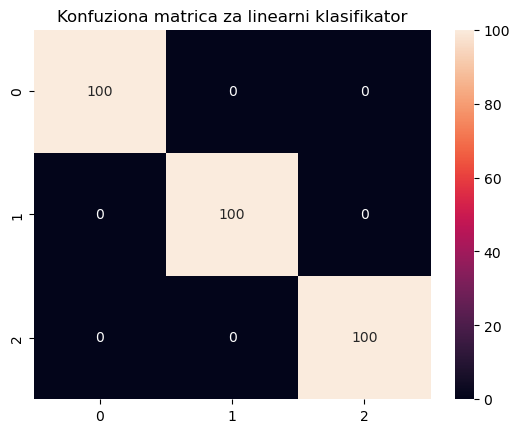

In [21]:
s12, v012, Neps_opt12, M1_est, M2_est, S1_est, S2_est = druga_numericka_metoda(X1, X2)

s13, v013, Neps_opt13, M1_est, M3_est, S1_est, S3_est = druga_numericka_metoda(X1, X3)

s23, v023, Neps_opt23, M2_est, M3_est, S2_est, S3_est = druga_numericka_metoda(X2, X3)

# Funkcija za donošenje odluke za jedan uzorak
def predict_sample(x):
    votes = {1: 0, 2: 0, 3: 0}

    V12 = np.linalg.inv(s12*S1_est + (1-s12)*S2_est) @ (M2_est - M1_est)
    if V12.T @ x > -v012:
        votes[2] += 1
    else:
        votes[1] += 1

    V13 = np.linalg.inv(s13*S1_est + (1-s13)*S3_est) @ (M3_est - M1_est)
    if V13.T @ x > -v013:
        votes[3] += 1
    else:
        votes[1] += 1

    V23 = np.linalg.inv(s23*S2_est + (1-s23)*S3_est) @ (M3_est - M2_est)
    if V23.T @ x > -v023:
        votes[3] += 1
    else:
        votes[2] += 1

    return max(votes, key=votes.get)

# Pravimo vektore stvarnih i predviđenih klasa
X_all = np.hstack([X1, X2, X3])  # sve tačke
y_true = np.array([1]*X1.shape[1] + [2]*X2.shape[1] + [3]*X3.shape[1])
y_pred = np.array([predict_sample(X_all[:, i]) for i in range(X_all.shape[1])])

cm = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Konfuziona matrica za linearni klasifikator')

Uočavamo 100% tačnosti, što smo i očekivali jer su klase linearno separabilne, pa možemo zaključiti da smo dobro odradili posao projekotvanja klasifikatora.

## b) Metoda zeljenih izlaza

Kod ove metode se primenjuje sledeće pravilo klasifikacije:
$$X \in \omega_1 \implies -V^TX-v_0>0$$
$$X \in \omega_2 \implies V^TX+v_0>0$$

Ovo se kompaknto može zapisati kao: $$W^{T}Z > 0$$ gde je 
$$\mathbf{W}^T =
\begin{bmatrix}
V_0 & V_1 & ... & V_n \\
\end{bmatrix}$$

$$X \in \omega_1 \implies
\mathbf{Z} =
\begin{bmatrix}
-1 \\
-X \\
\end{bmatrix}
$$

$$X \in \omega_1 \implies
\mathbf{Z} =
\begin{bmatrix}
1 \\
X \\
\end{bmatrix}
$$

Nepoznate parametre dobijamo na osnovu jednačine:$$UW=\Gamma$$ koristeći pseudo inverz se dobija konačno rešenje $$W = \left(U^TU\right)^{-1}U^T\Gamma$$, gde $U$ predstavlja:$$\mathbf{U} =
\begin{bmatrix}
Z_1^T \\
Z_2^T \\
.\\
.\\
.\\
Z_n^T \\
\end{bmatrix}$$

$\Gamma$ predstavlja vektor željenih izlaza i tu se nalazi definisana vrednost željenog izlaza za svaki odirak. Važnijim odbircima, odnosno onim odbircima kojim želimo da pridodamo veću pažnju tokom klasifikacije dodeljujemo veću vrednost željenog izlaza $\gamma_i$

Ovde ćemo takođe kao u delu pod a) projektujemo po 1 klasifikator za svaki par klasa. Svim odbircima ćemo inicijalno pridruživati jednake željene izlaze (1), pa ukoliko uvidimo da takav klasifikator nije dovoljno dobar razmotrićemo detaljnije šta treba uraditi.

### Klasifikator klase 1 i 2

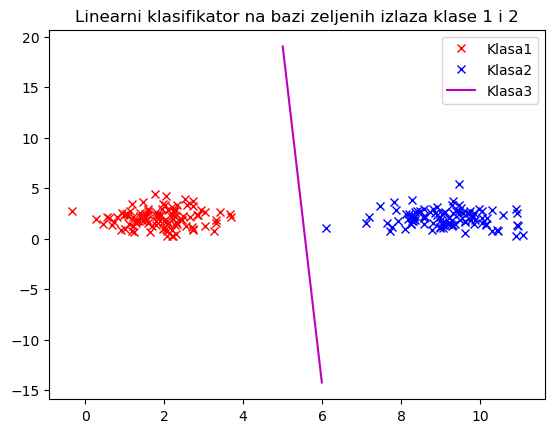

In [22]:
x0 = np.ones((1, N*2))
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X1, X2), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T

W = np.linalg.inv(U@U.T)@U@Gamma
v0_12= W[0]
v1_12 = W[1]
v2_12 = W[2]

x1 = np.arange(5,6,0.01)

x2 = -(v0_12+v1_12*x1)/v2_12

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(x1, x2, 'm')
plt.title("Linearni klasifikator na bazi zeljenih izlaza klase 1 i 2")
plt.legend(['Klasa1', 'Klasa2'])
plt.show()

### Klasifikator kalse 1 i 3

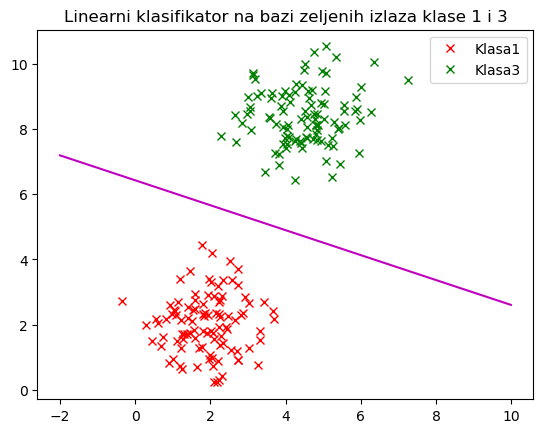

In [23]:
x0 = np.ones((1, N*2)) 
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X1, X3), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T

W = np.linalg.inv(U@U.T)@U@Gamma
v0_13 = W[0]
v1_13 = W[1]
v2_13 = W[2]

x1 = np.arange(-2,10,0.01)

x2 = -(v0_13+v1_13*x1)/v2_13

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.plot(x1, x2, 'm')
plt.title("Linearni klasifikator na bazi zeljenih izlaza klase 1 i 3")
plt.legend(['Klasa1', 'Klasa3'])
plt.show()


### Klasifikator klase 2 i 3

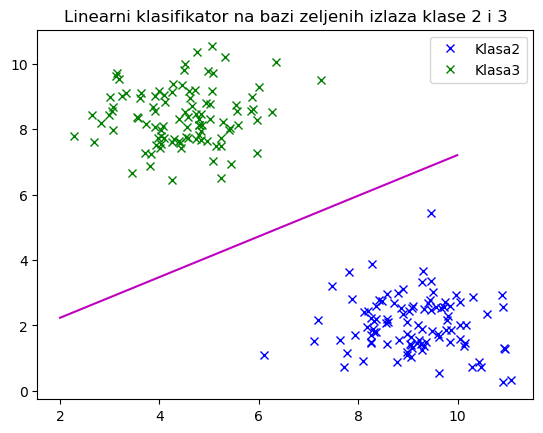

In [24]:
x0 = np.ones((1, N*2))
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X2, X3), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T

W = np.linalg.inv(U@U.T)@U@Gamma
v0_23 = W[0]
v1_23 = W[1]
v2_23 = W[2]

x1 = np.arange(2,10,0.01)

x2 = -(v0_23+v1_23*x1)/v2_23

plt.figure()
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.plot(x1, x2, 'm')
plt.title("Linearni klasifikator na bazi zeljenih izlaza klase 2 i 3")
plt.legend(['Klasa2', 'Klasa3'])
plt.show()


### Konfuziona matrica

In [32]:
N1 = X1.shape[1]
N2 = X2.shape[1]
N3 = X3.shape[1]

X = np.concatenate((X1,X2,X3), axis=1)
Y = np.zeros(X.shape[1])
Y[0:N1] = 1
Y[N1:N1+N2] = 2
Y[N1+N2:] = 3
Y_pred = np.zeros((N1+N2+N3, 3))

i1 = (X[0,:]*v1_12 + X[1,:]*v2_12 + v0_12) <= 0
i2 = (X[0,:]*v1_12 + X[1,:]*v2_12 + v0_12) > 0    
Y_pred[i1,0] = 1
Y_pred[i2,0] = 2

i1 = (X[0,:]*v1_13 + X[1,:]*v2_13 + v0_13) <= 0
i2 = (X[0,:]*v1_13 + X[1,:]*v2_13 + v0_13) > 0    
Y_pred[i1,1] = 1
Y_pred[i2,1] = 3

i1 = (X[0,:]*v1_23 + X[1,:]*v2_23 + v0_23) <= 0
i2 = (X[0,:]*v1_23 + X[1,:]*v2_23 + v0_23) > 0    
Y_pred[i1,2] = 2
Y_pred[i2,2] = 3

In [33]:
Y_pred_final = mode(Y_pred, axis=1).mode
Y_pred_final = Y_pred_final.reshape(-1,)

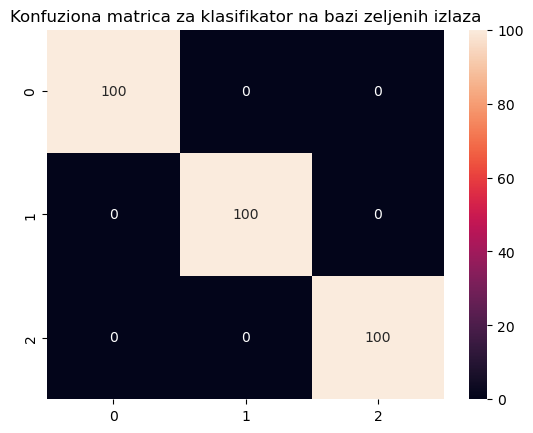

In [34]:
cm = confusion_matrix(Y, Y_pred_final)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Konfuziona matrica za klasifikator na bazi zeljenih izlaza')
plt.show()

I ovde dobijamo klasifikaciju bez greške.

### Ilustracija promene $\Gamma$

Trebalo bi da važi, da ukoliko odbircima prve klase dodamo veći željeni izlaz, klasifikator teži da njih bolje klasifikuje, pa će se klasifikaciona linija približiti drugoj klasi. Analogno važi ukoliko odbircima druge klase dodamo veću vrednos željenog izlaza.

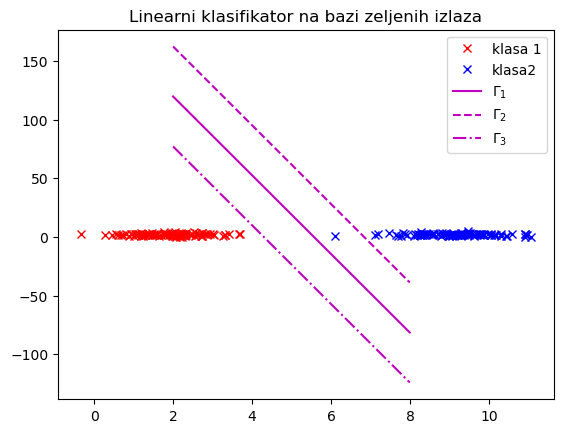

In [41]:
x0 = np.ones((1, N*2))
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X1, X2), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T
W = np.linalg.inv(U@U.T)@U@Gamma
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1 = np.arange(2,8,0.01)
x2 = -(v0+v1*x1)/v2

Gamma2 = np.ones((1, N*2)).T
Gamma2[0:N,0] = Gamma2[0:N,0]*2 
W = np.linalg.inv(U@U.T)@U@Gamma2
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_2 = np.arange(2,8,0.01)
x2_2 = -(v0+v1*x1)/v2

Gamma3 = np.ones((1, N*2)).T
Gamma3[0:N,0] = Gamma[0:N,0]*0.5
W = np.linalg.inv(U@U.T)@U@Gamma3
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_3 = np.arange(2,8,0.01)
x2_3 = -(v0+v1*x1)/v2

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(x1, x2, 'm')
plt.plot(x1_2, x2_2, 'm--')
plt.plot(x1_3, x2_3, 'm-.')
plt.legend(['klasa 1', 'klasa2', '$\Gamma_1$', '$\Gamma_2$', '$\Gamma_3$'])
plt.title("Linearni klasifikator na bazi zeljenih izlaza")
plt.show()

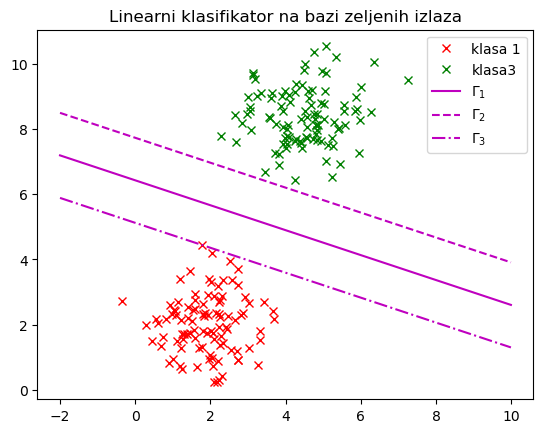

In [42]:
x0 = np.ones((1, N*2))
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X1, X3), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T
W = np.linalg.inv(U@U.T)@U@Gamma
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1 = np.arange(-2,10,0.01)
x2 = -(v0+v1*x1)/v2

Gamma2 = np.ones((1, N*2)).T
Gamma2[0:N,0] = Gamma2[0:N,0]*2 
W = np.linalg.inv(U@U.T)@U@Gamma2
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_2 = np.arange(-2,10,0.01)
x2_2 = -(v0+v1*x1)/v2

Gamma3 = np.ones((1, N*2)).T
Gamma3[0:N,0] = Gamma[0:N,0]*0.5
W = np.linalg.inv(U@U.T)@U@Gamma3
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_3 = np.arange(-2,10,0.01)
x2_3 = -(v0+v1*x1)/v2

plt.figure()
plt.plot(X1[0,:], X1[1,:], 'rx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.plot(x1, x2, 'm')
plt.plot(x1_2, x2_2, 'm--')
plt.plot(x1_3, x2_3, 'm-.')
plt.legend(['klasa 1', 'klasa3', '$\Gamma_1$', '$\Gamma_2$', '$\Gamma_3$'])
plt.title("Linearni klasifikator na bazi zeljenih izlaza")
plt.show()

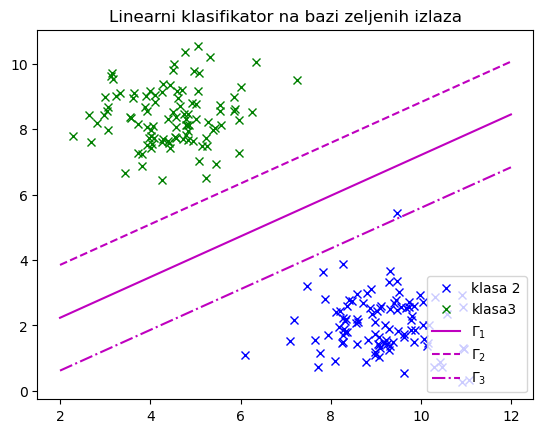

In [46]:
x0 = np.ones((1, N*2))
x0[0,0:N] = x0[0,0:N] * -1
X = np.concatenate((-X2, X3), axis=1)
U = np.concatenate((x0, X), axis=0)

Gamma = np.ones((1, N*2)).T
W = np.linalg.inv(U@U.T)@U@Gamma
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1 = np.arange(2,12,0.01)
x2 = -(v0+v1*x1)/v2

Gamma2 = np.ones((1, N*2)).T
Gamma2[0:N,0] = Gamma2[0:N,0]*2 
W = np.linalg.inv(U@U.T)@U@Gamma2
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_2 = np.arange(2,12,0.01)
x2_2 = -(v0+v1*x1)/v2

Gamma3 = np.ones((1, N*2)).T
Gamma3[0:N,0] = Gamma[0:N,0]*0.5
W = np.linalg.inv(U@U.T)@U@Gamma3
v0 = W[0]
v1 = W[1]
v2 = W[2]
x1_3 = np.arange(2,12,0.01)
x2_3 = -(v0+v1*x1)/v2

plt.figure()
plt.plot(X2[0,:], X2[1,:], 'bx')
plt.plot(X3[0,:], X3[1,:], 'gx')
plt.plot(x1, x2, 'm')
plt.plot(x1_2, x2_2, 'm--')
plt.plot(x1_3, x2_3, 'm-.')
plt.legend(['klasa 2', 'klasa3', '$\Gamma_1$', '$\Gamma_2$', '$\Gamma_3$'])
plt.title("Linearni klasifikator na bazi zeljenih izlaza")
plt.show()